In [1]:
import numpy as np
import matplotlib.pyplot as plt
import discretize
from scipy import sparse as sp

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG import Problem as simulation
from SimPEG import Survey as survey
from SimPEG import DataMisfit as data_misfit
from SimPEG import regularization
from SimPEG import Directives as directives
from SimPEG import Optimization as optimization
from SimPEG import InvProblem as inverse_problem
from SimPEG import Inversion as inversion

%matplotlib inline

# Create a mesh
We use the [discretize](http://discretize.simpeg.xyz/) package to create a mesh. It sets up the finite volume operators and keeps track of geometry. 

In [2]:
n = 100  # number of cells in the mesh
mesh = discretize.TensorMesh([n])

# Define a linear operator 
Kernels are decaying exponentials

In [3]:
nk = 20  # number of kernels
jk = np.linspace(1., 60., nk)
p = -0.25
q = 0.25

def g(k):
    return (
        np.exp(p*jk[k]*mesh.vectorCCx) *
        np.cos(np.pi*q*jk[k]*mesh.vectorCCx)
    )

In [4]:
G = np.vstack([g(k) for k in range(nk)])

Text(0.5, 1.0, 'columns of G')

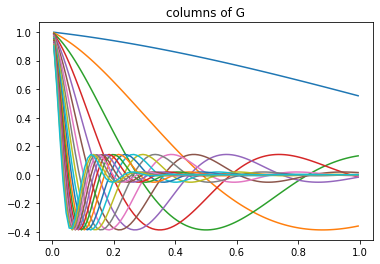

In [5]:
fig, ax = plt.subplots(1, 1)
ax.plot(mesh.vectorCCx, G.T)
ax.set_title("columns of G")

# Create a model

In [6]:
m = np.zeros(mesh.nC)

# add a boxcar
x_boxcar = np.r_[0.2, 0.35]
h_boxcar = 1
m[(mesh.vectorCCx >= x_boxcar.min()) & (mesh.vectorCCx <= x_boxcar.max())] = h_boxcar

# add a gaussian
x_gaussian = 0.65
h_gaussian = 0.8
s_gaussian = 0.05
m = m + h_gaussian * np.exp(-(mesh.vectorCCx - x_gaussian)**2 / (2*s_gaussian**2))

Text(0.5, 1.0, 'model')

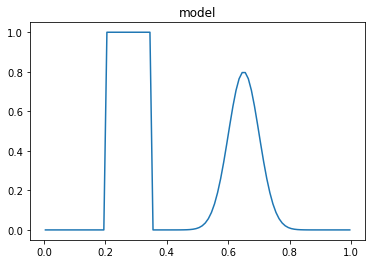

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(mesh.vectorCCx, m)
ax.set_title("model")

# Set up a simulation and create synthetic data

In [8]:
sim = simulation.LinearProblem(mesh, G=G)
linear_survey = survey.LinearSurvey()
sim.pair(linear_survey)

Text(0.5, 1.0, 'observed data')

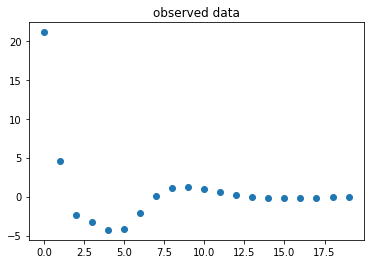

In [17]:
dobs = linear_survey.dpred(m)
linear_survey.dobs = dobs

fig, ax = plt.subplots(1, 1)
ax.plot(dobs, "o")
ax.set_title("observed data")

set a noise model for the data (used to construct weights in the data misfit term) 

# Set up the inversion

In [18]:
reg = regularization.Tikhonov(mesh, alpha_s=1., alpha_x=1.)  # regularization
dmis = data_misfit.l2_DataMisfit(linear_survey, std=0.01, eps=1e-2)  # data misfit
opt = optimization.InexactGaussNewton()  # optimization

to create your own regularization, inherit the `regularization.BaseRegularization` and define the 
- `__call__(self, m)`: evaluation of the regularization
- `deriv(self, m)`: evaluation of the derivative
- `deriv2(self, m, v=None)`: evaluation of the second derivative / second derivative times a vector if `v` is not None. (needed for second order optimization, but we can switch out to a gradient descent).

In [19]:
class MyRegularization(regularization.BaseRegularization):
    
    def __call__(self, m):
        return 0.5*m.dot(m)

    def deriv(self, m):
        return m
    
    def deriv2(self, m, v=None):
        if v is not None:
            return v
        return sp.eye(len(m))
        

In [20]:
my_reg = MyRegularization(mesh)
my_reg.test()

Testing MyRegularization Deriv
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.462e+00     5.333e-01      nan
 1   1.00e-02    1.982e-01     5.333e-03      2.000
 2   1.00e-03    1.934e-02     5.333e-05      2.000
 3   1.00e-04    1.929e-03     5.333e-07      2.000
========================= PASS! =========================
Go Test Go!

Testing MyRegularization Deriv2
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.579e+00     1.865e-14      nan
 1   1.00e-02    3.579e-01     1.182e-14      0.198
 2   1.00e-03    3.579e-02     1.113e-14      0.026
 3   1.00e-04    3.579e-03     8.218e-15      0.132
========================= PASS! =========================
Yay passed!



True

Statement of the inverse problem

$$
\min_\mathbf{m} \phi = \phi_d + \beta \phi_m
$$

- $\phi_d$: `dmis`
- $\phi_m$: `reg`

In [37]:
# could substitute your own regularization here too (or add them together reg = reg1 + reg2)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt) 
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)  # computes phid, phim of a random vector and weights the ratio
target_misfit = directives.TargetMisfit()  # stop the inversion once phi_d <= phi_d*
inv = inversion.BaseInversion(inv_prob, [beta, target_misfit])

The callback on the InexactGaussNewton Optimization was replaced.


In [38]:
m0 = np.zeros(mesh.nC)  # initial guess
mrec = inv.run(m0)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.79e-01  2.73e+04  0.00e+00  2.73e+04    1.90e+04      0              
   1  2.79e-01  2.13e+03  6.13e+00  2.13e+03    2.53e+03      0              
   2  2.79e-01  4.74e+02  1.05e+01  4.77e+02    2.54e+03      0              
   3  2.79e-01  2.49e+02  1.30e+01  2.53e+02    2.64e+03      0   Skip BFGS  
   4  2.79e-01  1.76e+02  1.30e+01  1.79e+02    1.30e+03      0              
   5  2.79e-01  1.46e+02  1.36e+01  1.50e+02    1.47e+03      0              
   6  2.79e-01  1.27e+02  1.43e+01  1.31e+02    1.23e+03      0              
   7  2.79e-01  1.25e+02  1.43e+01  1.29e+

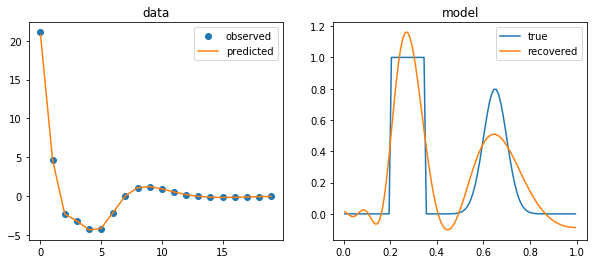

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(dobs, 'o', label="observed")
ax[0].plot(inv_prob.dpred, label="predicted")
ax[0].set_title("data")
ax[0].legend()

ax[1].plot(mesh.vectorCCx, m, label="true")
ax[1].plot(mesh.vectorCCx, mrec, label="recovered")
ax[1].set_title("model")
ax[1].legend()